## Univariate Multi-Step CNN

In [10]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

In [11]:
def univariate_multi_step(sequence, window_size, n_multistep):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + window_size
        out_ix = end_ix + n_multistep
        # check if we are beyond the sequence
        if out_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

## Hyper parameter

In [29]:
split_ratio = 0.70
num_epochs = 4
window_size = 3
batch_size = 1
n_step = 2
learning_rate = 0.1
# seed
torch.manual_seed(123)

## Data Preparation

In [30]:
# Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])

split_data = round(len(univariate_series) * split_ratio)
# split data by indexing
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Normalization

In [31]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))

## Data Sequencing

In [32]:
trainX, trainY = univariate_multi_step(train_data_normalized, window_size, n_step)
testX, testY = univariate_multi_step(test_data_normalized, window_size, n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testX shape:{testY.shape}")

trainX shape:(24, 3, 1) trainY shape:(24, 2, 1)

testX shape:(8, 3, 1) testX shape:(8, 2, 1)


## Data Transform

In [33]:
# transfrom to Pytorch tensor
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([24, 3, 1]) trainY shape:torch.Size([24, 2, 1])

testX shape:torch.Size([8, 3, 1]) testY shape:torch.Size([8, 2, 1])


In [34]:
# Data Transpose to suit for CNN 
trainX = torch.transpose(trainX, 1, 2)
testX = torch.transpose(testX, 1, 2)

print(f"after transpose trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"after transpose shape:{testX.shape} testY shape:{testY.shape}")

after transpose trainX shape:torch.Size([24, 1, 3]) trainY shape:torch.Size([24, 2, 1])

after transpose shape:torch.Size([8, 1, 3]) testY shape:torch.Size([8, 2, 1])


In [35]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## CNN Configuration

In [36]:
class CNN_Multistep(nn.Module):

    def __init__(self,timeseries,n_step):
        super(CNN_Multistep, self).__init__()
        self.timeseries=timeseries
        self.n_step = n_step
        
        # Conv1d1d kernel_size is base on the number of time series
        self.conv1 = nn.Conv1d(in_channels=self.timeseries, out_channels=64, kernel_size=2)
        
        # Maxpool1d kernel_size is base on the number of time series
        # For example Input:(N,C,Lin) Output : (N,C,Lout)
        self.poo1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64, 50)
        self.fc2 = nn.Linear(50,n_step)

    def forward(self, x):
        
        x = self.poo1(F.relu(self.conv1(x)))
        
        # Flatten
        x = x.view(-1,64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Model Deployment

In [37]:
model = CNN_Multistep(timeseries=trainX.shape[1], n_step=n_step)
print(model.eval())
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

CNN_Multistep(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [38]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN_Multistep(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

## Training

In [39]:
def training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
        #     Don't do this if you want your LSTM to be stateful
        #     model.hidden = model.init_hidden()
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to perform MSE
            y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0], train_Y.shape[1],train_Y.shape[2]))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            running_loss_train += loss_train.item()

        epoch_loss_train = running_loss_train / len(train_X)
        train_loss[t] = epoch_loss_train

        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to perform MSE
                y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], test_Y.shape[1],test_Y.shape[2]))
                loss_test = loss_fn(y_test_pred, test_Y)
                running_loss_valid += loss_test.item()

        epoch_loss_test = running_loss_valid / len(test_X)

        val_loss[t] = epoch_loss_test

    return train_loss, val_loss

In [40]:
train_loss, val_loss = training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

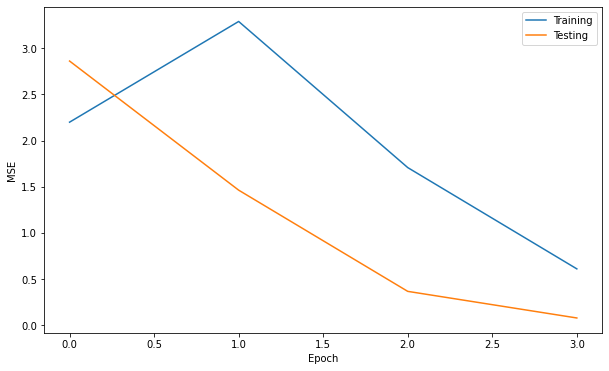

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Inference

In [42]:
# make predictions
y_train_prediction = model(trainX)
y_test_prediction = model(testX)

In [43]:
# Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction, (y_train_prediction.shape[0], y_train_prediction.shape[1]))
trainY = torch.reshape(trainY, (trainY.shape[0], trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction, (y_test_prediction.shape[0], y_test_prediction.shape[1]))
testY = torch.reshape(testY, (testY.shape[0], testY.shape[1]))

In [44]:
# Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [45]:
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

[310. 320.]		[315.2844  321.11963]
[320. 330.]		[323.58014 329.0546 ]
[330. 340.]		[332.02872 337.0963 ]
[340. 350.]		[340.55728 345.2829 ]
[350. 360.]		[349.1671  353.66266]
[360. 370.]		[357.72968 362.05292]
[370. 380.]		[366.27515 370.36615]
[380. 390.]		[374.32474 378.1254 ]


In [46]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.82 RMSE
Test Score: 3.48 RMSE


## Exercise for Univariate (Solution)

In [149]:
#Hyperparameter
num_epochs_shampoo = 120
split_ratio = 0.70
n_step_shampoo = 2
batch_size_shampoo = 1
window_size_shampoo = 3
learing_rate_shampoo = 0.001

#seed
torch.manual_seed(123)

In [150]:
shampoo = pd.read_csv(r'C:\Users\boonkai.yeoh\Desktop\shampoo-sales.csv')
# shampoo = pd.read_csv('../datasets/others/shampoo-sales.csv')
shampoo_ts =shampoo['sales']
shampoo_ts.head()

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
Name: sales, dtype: float64

In [151]:
#split data by indexing 
split_data = round(len(shampoo_ts)*split_ratio)
split_data

25

In [152]:
train_data_shampoo = shampoo_ts[:split_data]
test_data_shampoo = shampoo_ts[split_data:]
train_time = shampoo_ts.index[:split_data]
test_time = shampoo_ts.index[split_data:]
print("train_data_shampoo_shape")
print(train_data_shampoo.shape)
print("test_data_shampoo_shape")
print(test_data_shampoo.shape)

train_data_shampoo_shape
(25,)
test_data_shampoo_shape
(11,)


In [153]:
#Data Normalization

#Reshape before normalize
train_data_shampoo = train_data_shampoo.values.reshape(-1, 1)
test_data_shampoo = test_data_shampoo.values.reshape((-1, 1))

#Build Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized_shampoo = scaler.fit_transform(train_data_shampoo)

test_data_normalized_shampoo = scaler.fit_transform(test_data_shampoo)
train_data_normalized_shampoo[1:6]

array([[-0.82401588],
       [-0.57790275],
       [-1.        ],
       [-0.59642739],
       [-0.67449553]])

In [154]:
#Data Sequencing 
trainX_shampoo ,trainY_shampoo =  univariate_multi_step(train_data_normalized_shampoo,window_size_shampoo,n_step_shampoo)
testX_shampoo , testY_shampoo = univariate_multi_step(test_data_normalized_shampoo,window_size_shampoo,n_step_shampoo)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testY shape:{testY_shampoo.shape}")

trainX shape:(21, 3, 1) trainY shape:(21, 2, 1)

testX shape:(7, 3, 1) testY shape:(7, 2, 1)


In [155]:
#Transfrom numpy to Pytorch tensor
trainX_shampoo = torch.from_numpy(trainX_shampoo).type(torch.Tensor)
trainY_shampoo = torch.from_numpy(trainY_shampoo).type(torch.Tensor)
testX_shampoo = torch.from_numpy(testX_shampoo).type(torch.Tensor)
testY_shampoo = torch.from_numpy(testY_shampoo).type(torch.Tensor)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:torch.Size([21, 3, 1]) trainY shape:torch.Size([21, 2, 1])

testX shape:torch.Size([7, 3, 1]) testX shape:torch.Size([7, 2, 1])


In [156]:
# Data Transpose to suit for CNN 
trainX_shampoo = torch.transpose(trainX_shampoo, 1, 2)
testX_shampoo= torch.transpose(testX_shampoo, 1, 2)

print(f"after transpose trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"after transpose shape:{testX.shape} testY shape:{testY.shape}")

after transpose trainX shape:torch.Size([24, 1, 3]) trainY shape:torch.Size([24, 2])

after transpose shape:torch.Size([8, 1, 3]) testY shape:torch.Size([8, 2])


In [157]:
# Create Iterator
train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)
train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

test_dataset_shampoo = TensorDataset(testX_shampoo, testY_shampoo)
test_iter_shampoo = DataLoader(test_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

In [158]:
model_shampoo = CNN_Multistep(timeseries=trainX_shampoo.shape[1], n_step=n_step_shampoo)
print(model_shampoo.eval())
optimiser_shampoo = torch.optim.Adam(model_shampoo.parameters(), lr=learing_rate_shampoo)
loss_fn_shampoo = nn.MSELoss()

CNN_Multistep(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [159]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model_shampoo.apply(weights_init)

CNN_Multistep(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

In [160]:
train_loss_shampoo,val_loss_shampoo = training(num_epochs_shampoo,train_iter_shampoo,test_iter_shampoo,optimiser_shampoo,loss_fn_shampoo,model_shampoo)

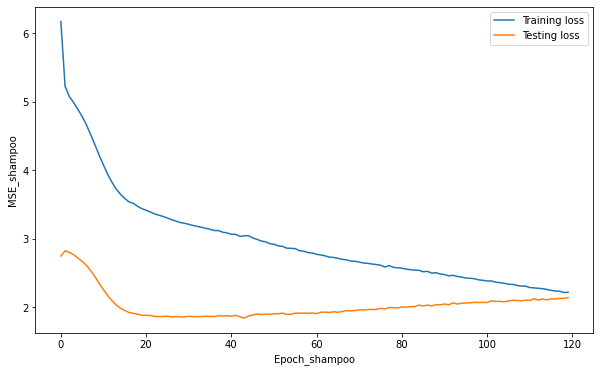

In [161]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo, label="Training loss")
plt.plot(val_loss_shampoo, label="Testing loss")
plt.xlabel("Epoch_shampoo")
plt.ylabel("MSE_shampoo")
plt.legend()
plt.show()

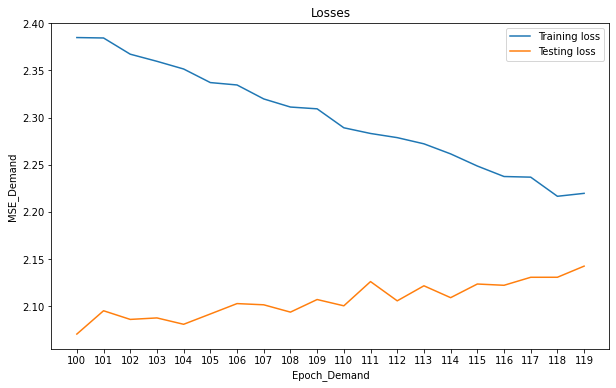

In [163]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 100
end_epoch = 120
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_shampoo[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

In [167]:
#Make predictions
with torch.no_grad():
    y_train_prediction_shampoo= model_shampoo(trainX_shampoo)
    y_test_prediction_shampoo= model_shampoo(testX_shampoo)

#Reshape to original data
y_train_prediction_shampoo = torch.reshape(y_train_prediction_shampoo,(y_train_prediction_shampoo.shape[0],y_train_prediction_shampoo.shape[1]))
trainY_shampoo = torch.reshape(trainY_shampoo,(trainY_shampoo.shape[0],trainY_shampoo.shape[1]))
y_test_prediction_shampoo = torch.reshape(y_test_prediction_shampoo,(y_test_prediction_shampoo.shape[0],y_test_prediction_shampoo.shape[1]))
testY_shampoo = torch.reshape(testY_shampoo,(testY_shampoo.shape[0],testY_shampoo.shape[1]))

In [168]:
#Invert predictions
y_train_pred_shampoo = scaler.inverse_transform(y_train_prediction_shampoo.detach().numpy())
y_train_shampoo = scaler.inverse_transform(trainY_shampoo.detach().numpy())
y_test_pred_shampoo = scaler.inverse_transform(y_test_prediction_shampoo.detach().numpy())
y_test_shampoo = scaler.inverse_transform(testY_shampoo.detach().numpy())

In [169]:
for i in range(len(y_test_shampoo)):
    print(f"{y_test_shampoo[i]}\t\t{y_test_pred_shampoo[i]}")

[401.30002 437.4    ]		[377.42908 381.259  ]
[437.4 575.5]		[398.56326 399.45346]
[575.5     407.60004]		[445.40906 464.09662]
[407.60004 682.     ]		[542.7855  548.20465]
[682.  475.3]		[532.65784 566.5082 ]
[475.3 581.3]		[560.745  554.8669]
[581.3 646.9]		[567.1936 536.2129]


In [170]:
#calculate root mean squared error
trainScore_shampoo = math.sqrt(mean_squared_error(y_train_shampoo[:,0], y_train_pred_shampoo[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_shampoo))
testScore_shampoo = math.sqrt(mean_squared_error(y_test_shampoo[:,0], y_test_pred_shampoo[:,0]))
print('Test Score: %.2f RMSE' % (testScore_shampoo))

Train Score: 61.78 RMSE
Test Score: 97.89 RMSE


## Plot Explanation
- Blue Line-Indicate as test data before sequencing
- Green Line-Indicate as the testY data after sequencing
- Red Line-Indicate as the predicted testY data (Forecast) after sequencing 

Window size = 4 , hence the time need start from +3 due to taking 3 data point as x-feature.

- **x-feature = window size -1**

[ time+3,time+4 ] - This is because n_step_demand = 2 .If n_step_demand = 3 ,[ time+3,time+4,time_5 ] is need

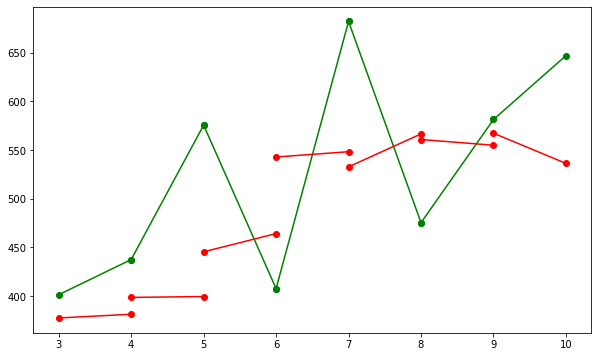

In [171]:
# Plot testY and predictionY data
plt.figure(figsize=(10,6))

for time in range(len(y_test_shampoo)):
        TestY_data=[y_test_shampoo[time][0],y_test_shampoo[time][1]]
        plt.plot([time+window_size_shampoo,time+window_size_shampoo+1],TestY_data,color="green",marker='o',label='TestY')
    
        text_prediction_data=[y_test_pred_shampoo[time][0],y_test_pred_shampoo[time][1]]
        plt.plot([time+window_size_shampoo,time+window_size_shampoo+1], text_prediction_data,color="red",marker='o',label='Forecast')

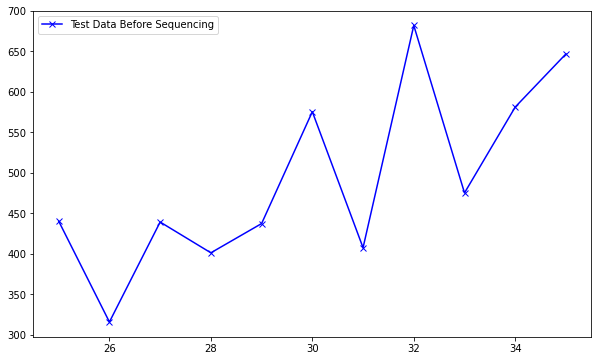

In [172]:
# Plot Original Test Data
plt.figure(figsize=(10,6))
plt.plot(test_time,test_data_shampoo,marker='x',color="blue",label="Test Data Before Sequencing")
plt.legend()

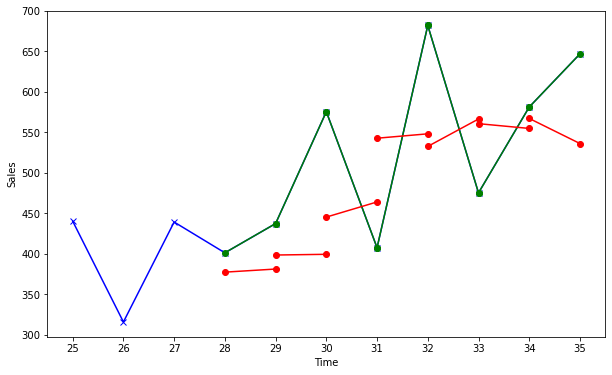

In [173]:
# Plot orginal test data , testY and predict testY after sequencing 
plt.figure(figsize=(10,6))
position = range(len(test_data_shampoo))
label=test_time
plt.xticks(position, label)
plt.plot(test_data_shampoo[:,-1],marker='x',color="blue",label="Test Data Before Sequencing")
plt.xlabel("Time")
plt.ylabel("Sales")

for time in range(len(y_test_shampoo)):
        TestY_data=[y_test_shampoo[time][0],y_test_shampoo[time][1]]
        plt.plot([time+window_size_shampoo,time+window_size_shampoo+1],TestY_data,color="green",marker='o',label='TestY')
    
        text_prediction_data=[y_test_pred_shampoo[time][0],y_test_pred_shampoo[time][1]]
        plt.plot([time+window_size_shampoo,time+window_size_shampoo+1], text_prediction_data,color="red",marker='o',label='Forecast')

## Reference
1. https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
2. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee